# Best model for numerical and text data

In [11]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# auxiliary functions
def get_numericals(df):
    df['therapeutic_number'] = df['Therapeutic area'].apply(lambda x: x.count(',') + 1)
    df = df.select_dtypes(exclude='object')
    return df

def percentage_columns(df,column_list):
    print(df['n_trials'].head())
    for column in column_list:
        df[column]=((df[column]*100)/df['n_trials']).replace([np.inf, -np.inf, np.nan], 0)
    return df

In [13]:
raw_data = pd.read_csv('../raw_data/wra_CT_PM_conclusions.csv')

numericals = get_numericals(raw_data)

percent_list= ['status_not_yet_recruiting', 'status_recruiting',
       'status_enrolling_by_invitation', 'status_active_not_recruiting',
       'status_suspended', 'status_terminated', 'status_completed',
       'status_withdrawn', 'status_unknown', 'org_fed', 'org_indiv',
       'org_industry', 'org_network', 'org_nih', 'org_other', 'org_other_gov',
       'phase_early_1', 'phase_not_applicable', 'phase_1', 'phase_2',
       'phase_3', 'phase_4', 'pm_results'] 

numericals = numericals.drop(labels=['Unnamed: 0', 'Authorisation status'], axis=1)

columns_names = numericals.columns.to_list()
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(numericals[columns_names])
scaled_numericals = pd.DataFrame(scaled_array, columns=columns_names)

data = raw_data[['conclusions', 'Authorisation status']]

merged = pd.merge(data, scaled_numericals, left_index=True, right_index=True)

merged_filled = merged.fillna('')

conclusions = merged_filled['conclusions']

tf_idf_vectorizer = TfidfVectorizer(max_df = 0.8, min_df=0.5, max_features = 50, ngram_range=(1, 1))
X = tf_idf_vectorizer.fit_transform(conclusions)
X.toarray()
vectorized = pd.DataFrame(X.toarray(),columns = tf_idf_vectorizer.get_feature_names())

clean_numericals = merged_filled.drop(labels=['conclusions'], axis=1).dropna()

X = clean_numericals.join(vectorized)

y = X['Authorisation status'].astype('int64')

X = X.drop(labels=['Authorisation status'], axis=1)


0.5


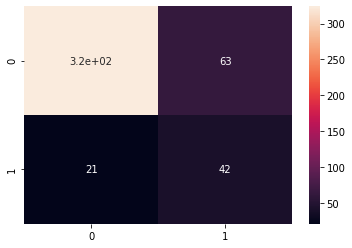

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=34, stratify=y)
clf = RandomForestClassifier(max_depth=3, random_state=23, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(f1_score(y_test, y_pred))